In [1]:
import os
import logging, timeit
#from btEngine2.DataLoader import DataLoader
from btEngine2.MarketData import MarketData
from btEngine2.TradingRule import TradingRule

import platform
import pandas as pd

pd.options.display.float_format = lambda x: f'{x:,.0f}' if abs(x) >= 1000 else (f'{x:.2f}' if abs(x) < 10 else f'{x:.1f}')
# Detect operating system
if platform.system() == "Windows":
    ticker_csv_path = r'G:\Projects\BackTesting1.0\Data\Inputs\TickerList-Futs.csv'
    save_directory = r"G:\Projects\BackTesting1.0\Data\Bloomberg\Futures"
    helper_directory = r'G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles'
    bt_folder = r'BackTests\skew_resrch'
else:  # Assume macOS for other cases
    ticker_csv_path = r'Data/Inputs/TickerList-Futs.csv'
    save_directory = r"Data/Bloomberg/Futures"
    helper_directory = r'Data/Bloomberg/HelperFiles'
    bt_folder = r'BackTests/skew_resrch'

# Define paths to auxiliary data for MarketData
tick_values_path = os.path.join(helper_directory, 'fut_val_pt.parquet')
fx_rates_path = os.path.join(helper_directory, 'fxHist.parquet')

# Initialize the MarketData
market_data = MarketData(
    base_directory=save_directory,
    tick_values_path=tick_values_path,
    fx_rates_path=fx_rates_path,
    instrument_type="Futures",
    n_threads=8,  # Number of threads for parallel data loading
    log_level=logging.ERROR  # Set to DEBUG for more detailed logs
)


In [2]:
tick = 'CA1 Index'
# Access data for a specific ticker
try:
    test_df = market_data.get_ticker_data(tick)
    print(test_df)
except ValueError as e:
    print(e)

# Access all preprocessed data
all_data = market_data.get_data()
print(f"Total tickers loaded: {len(all_data)}")

# Access FX rates
fx_rates = market_data.get_fx_rates()
# Access tick values
tick_values = market_data.get_tick_values()
# Access asset classes
asset_classes = market_data.get_asset_classes()

#market_data = market_data.date_filter(start_date='01012010')

shape: (6_045, 14)
┌────────────┬────────┬────────┬────────┬───┬─────────┬─────────┬─────────────────┬────────────────┐
│ Date       ┆ Open   ┆ High   ┆ Low    ┆ … ┆ BadOHLC ┆ FX_Rate ┆ Tick_Value_Base ┆ Tick_Value_USD │
│ ---        ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---     ┆ ---     ┆ ---             ┆ ---            │
│ date       ┆ f64    ┆ f64    ┆ f64    ┆   ┆ bool    ┆ f64     ┆ f64             ┆ f64            │
╞════════════╪════════╪════════╪════════╪═══╪═════════╪═════════╪═════════════════╪════════════════╡
│ 2001-03-19 ┆ null   ┆ null   ┆ null   ┆ … ┆ false   ┆ 0.8999  ┆ 50.0            ┆ 44.995         │
│ 2001-03-20 ┆ 234.2  ┆ 234.2  ┆ 231.2  ┆ … ┆ false   ┆ 0.9094  ┆ 50.0            ┆ 45.47          │
│ 2001-03-21 ┆ 220.0  ┆ 223.2  ┆ 220.0  ┆ … ┆ false   ┆ 0.8965  ┆ 50.0            ┆ 44.825         │
│ 2001-03-22 ┆ 220.0  ┆ 223.2  ┆ 220.0  ┆ … ┆ false   ┆ 0.8892  ┆ 50.0            ┆ 44.46          │
│ 2001-03-23 ┆ 213.2  ┆ 215.2  ┆ 213.2  ┆ … ┆ false   ┆ 0.8899  ┆ 50.0  

In [3]:

pSizeParams = {
    'AssetVol': 5_000_000,  # Target asset volatility in USD
    'VolLookBack': 30,
    'VolMethod': 'ewm'  # Lookback period for volatility calculation
}


In [4]:
from btEngine2.Rules.Convergent.abs_skew import *

<Axes: xlabel='Date'>

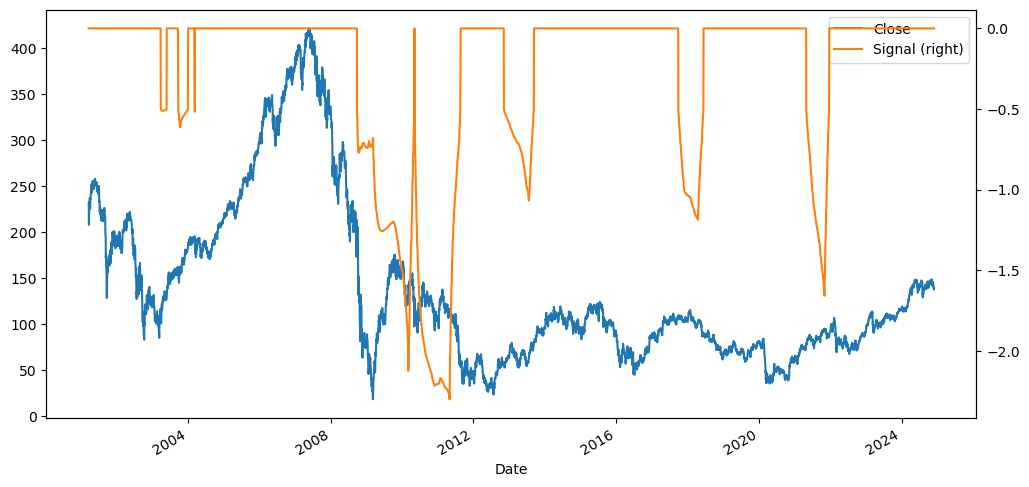

In [5]:
test_sig = abs_skew_short(test_df, N=252, min_sig = 0.5).to_pandas()

test_sig.set_index('Date', inplace=True)

test_sig[['Close', 'Signal']].plot(secondary_y='Signal', figsize=(12, 6))

<Axes: xlabel='Date'>

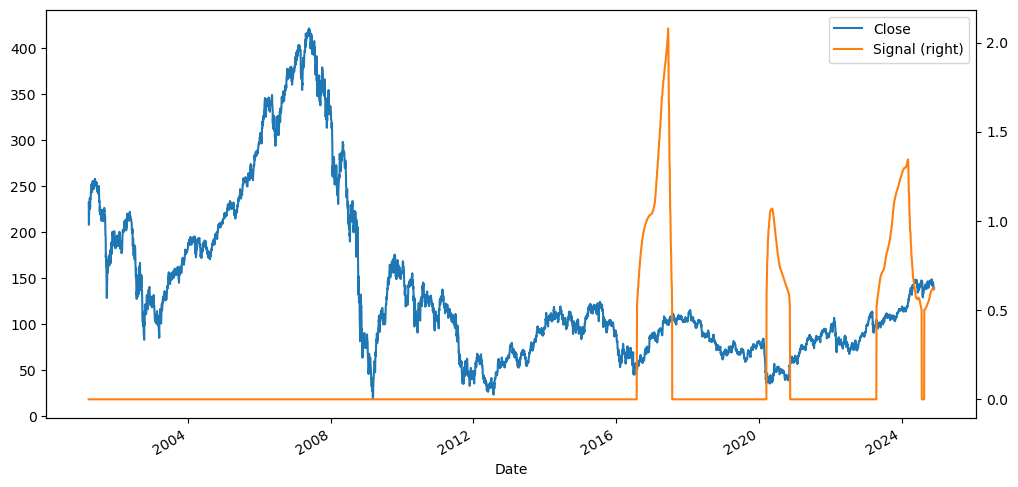

In [6]:
test_sig = abs_skew_long(test_df, N=252, min_sig = 0.5).to_pandas()

test_sig.set_index('Date', inplace=True)

test_sig[['Close', 'Signal']].plot(secondary_y='Signal', figsize=(12, 6))

In [7]:
skew_params = dict(N=252, min_sig=0.15, lag=2)
skew_params_s = dict(N=252, min_sig=0.25)
skew_params_ls = dict(N=252, size_factor_s=0.5 ,min_sig_l=0.15, min_sig_s=0.3)
skew_sizing = dict(AssetVol=r'Data/Inputs/AssetSizing-Futs.csv', VolLookBack=30, VolMethod='ewm')

exclude = ['eq-divf', 'eq-vol'] + [x for x in asset_classes if 'comm-' in x] + [x for x in asset_classes if 'fx-' in x] + ['stir'] + ['eq-as']
exclude


['eq-divf',
 'eq-vol',
 'comm-soft',
 'comm-base',
 'comm-enrgy',
 'comm-prec',
 'fx-dm',
 'fx-em',
 'stir',
 'eq-as']

In [8]:
skew_long = TradingRule(
    market_data=market_data,
    trading_rule_function=abs_skew_long,
    trading_params=skew_params,
    position_sizing_params=skew_sizing,  # Define as needed
    name_label=f'skew_long_{skew_params["N"]}',
    excl_ac=exclude,
    strat_descr= f'Skew Long Strategy with N {skew_params['N']}',
    log_level=logging.ERROR,
    bt_folder = bt_folder
)

skew_short = TradingRule(
    market_data=market_data,
    trading_rule_function=abs_skew_short,
    trading_params=skew_params_s,
    position_sizing_params=skew_sizing,  # Define as needed
    name_label=f'skew_long_{skew_params["N"]}',
    excl_ac = ['eq-divf'],
    strat_descr= f'Skew Short Strategy with N {skew_params['N']}',
    log_level=logging.ERROR,
    bt_folder = bt_folder
)

skew_combined = TradingRule(
    market_data=market_data,
    trading_rule_function=abs_skew_combined,
    trading_params=skew_params_ls,
    position_sizing_params=skew_sizing,  # Define as needed
    name_label=f'skew_ls_{skew_params["N"]}',
    excl_ac = exclude,
    strat_descr= f'Skew Long/Short Strategy with N {skew_params['N']}',
    log_level=logging.ERROR,
    bt_folder = bt_folder
)

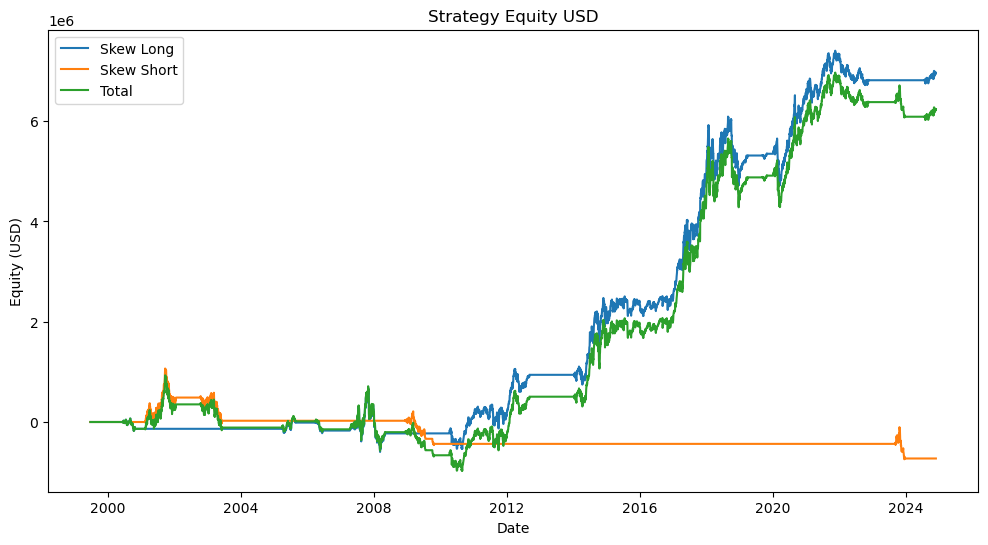

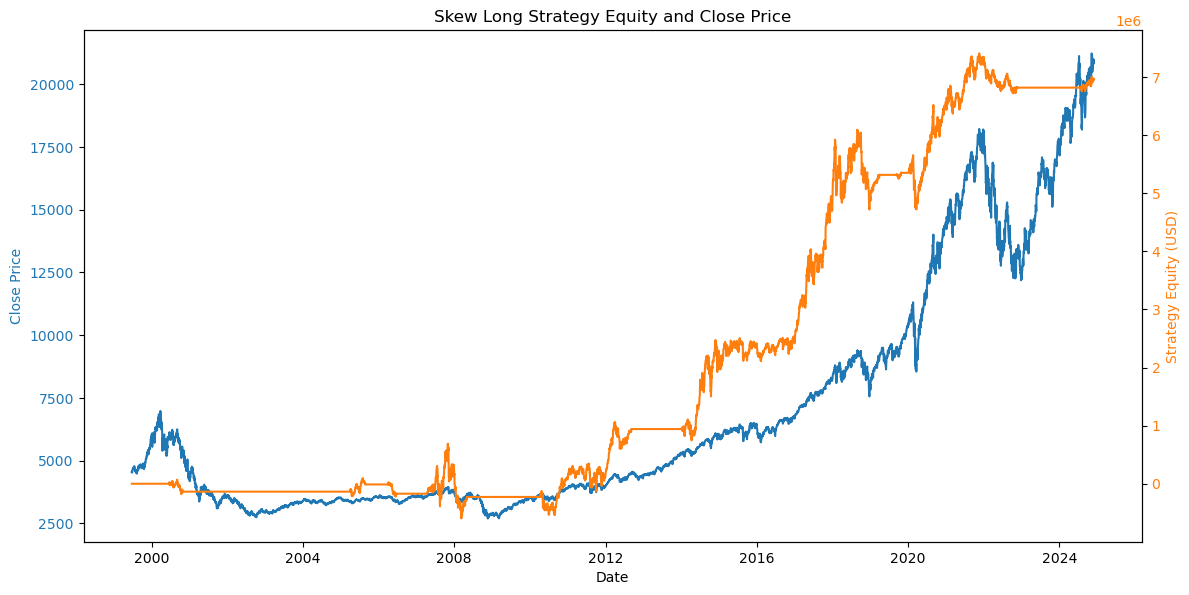

In [9]:
ticker = 'NQ1 Index'
# Backtest for skew_long
estest_long = skew_long.backtest_asset(ticker)
# Backtest for skew_short
estest_short = skew_short.backtest_asset(ticker)

# Plot the Strategy_Equity_USD for each and total on the same plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(estest_long['Date'], estest_long['Strategy_Equity_USD'], label='Skew Long')
plt.plot(estest_short['Date'], estest_short['Strategy_Equity_USD'], label='Skew Short')
plt.plot(estest_long['Date'], estest_long['Strategy_Equity_USD'] + estest_short['Strategy_Equity_USD'], label='Total')
plt.legend()
plt.title('Strategy Equity USD')
plt.xlabel('Date')
plt.ylabel('Equity (USD)')
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the Close price
ax1.plot(estest_long['Date'], estest_long['Close'], color='tab:blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis to plot the Strategy Equity
ax2 = ax1.twinx()
ax2.plot(estest_long['Date'], estest_long['Strategy_Equity_USD'], color='tab:orange', label='Strategy Equity')
ax2.set_ylabel('Strategy Equity (USD)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Skew Long Strategy Equity and Close Price')
plt.show()

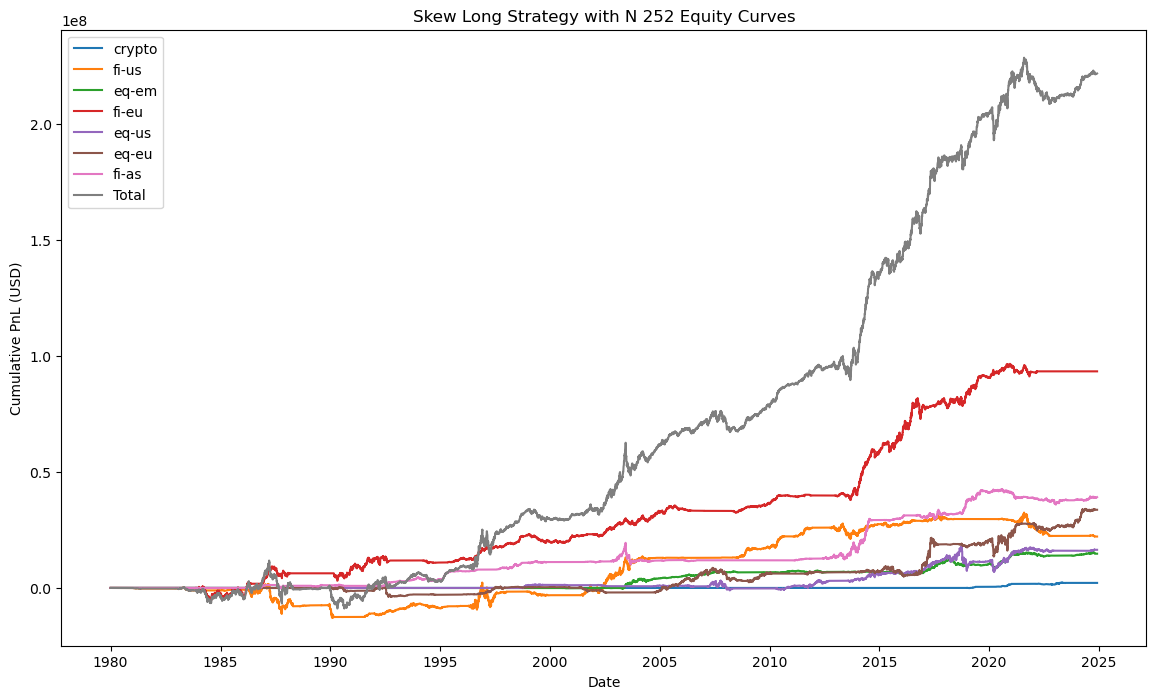

,crypto,fi-us,eq-em,fi-eu,eq-us,eq-eu,fi-as,Total
Date,,,,,,,,
1980-01-02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1980-01-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1980-01-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1980-01-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1980-01-08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...
2024-11-25,"2,180,958","22,174,643","14,769,404","93,410,997","16,451,951","33,717,859","39,062,925","221,768,737"
2024-11-26,"2,180,958","22,174,643","14,769,404","93,410,997","16,451,951","33,717,859","39,073,015","221,778,827"
2024-11-27,"2,180,958","22,174,643","14,769,404","93,410,997","16,451,951","33,717,859","39,089,368","221,795,180"


In [10]:
skew_long.plot_equity(byac=True)

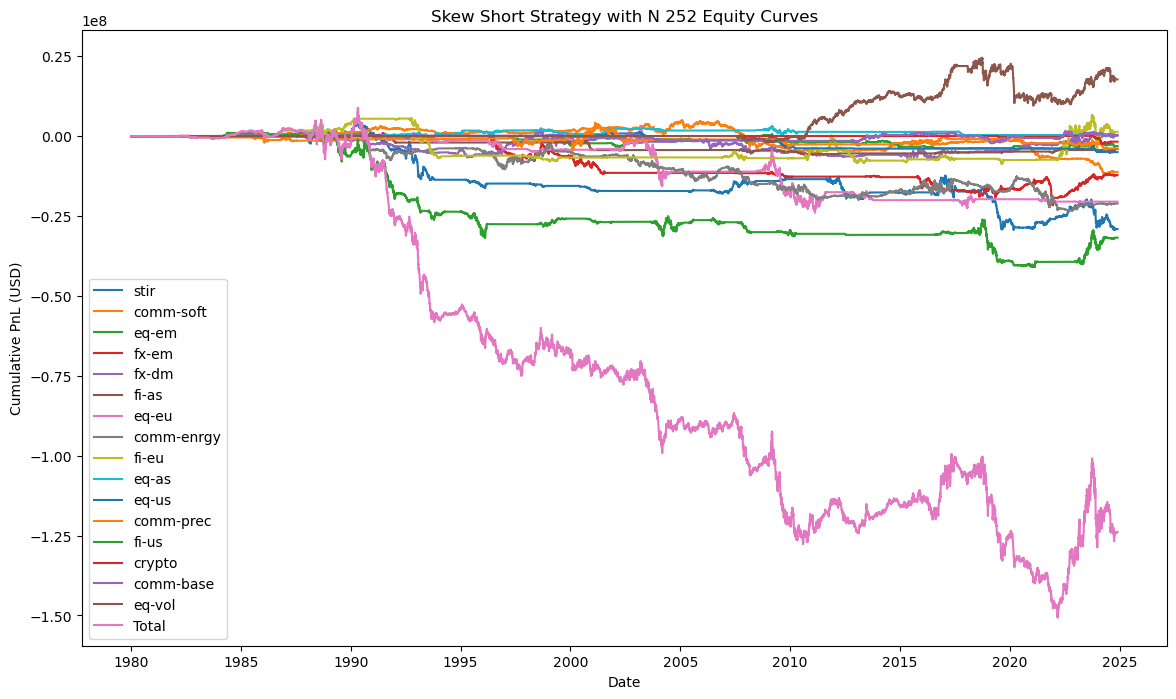

,stir,comm-soft,eq-em,fx-em,fx-dm,fi-as,eq-eu,comm-enrgy,fi-eu,eq-as,eq-us,comm-prec,fi-us,crypto,comm-base,eq-vol,Total
Date,,,,,,,,,,,,,,,,,
1980-01-02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1980-01-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1980-01-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1980-01-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1980-01-08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25,"-29,087,452","-11,206,764","-3,149,880","-12,207,532","147,253","-4,060,408","-20,518,358","-21,127,690","1,330,584","341,114","-5,016,930","-3,867,831","-31,796,469","-1,752,426","219,144","17,724,511","-124,029,135"
2024-11-26,"-29,087,452","-11,206,764","-3,149,880","-12,181,536","147,253","-4,060,408","-20,518,358","-21,127,690","1,330,584","341,114","-5,016,930","-3,867,831","-31,796,469","-1,752,426","263,054","17,724,511","-123,959,229"
2024-11-27,"-29,087,452","-11,206,764","-3,149,880","-12,185,442","147,253","-4,060,408","-20,518,358","-21,127,690","1,330,584","341,114","-5,016,930","-3,867,831","-31,796,469","-1,752,426","284,027","17,724,511","-123,942,162"


In [11]:
skew_short.plot_equity(byac=True)

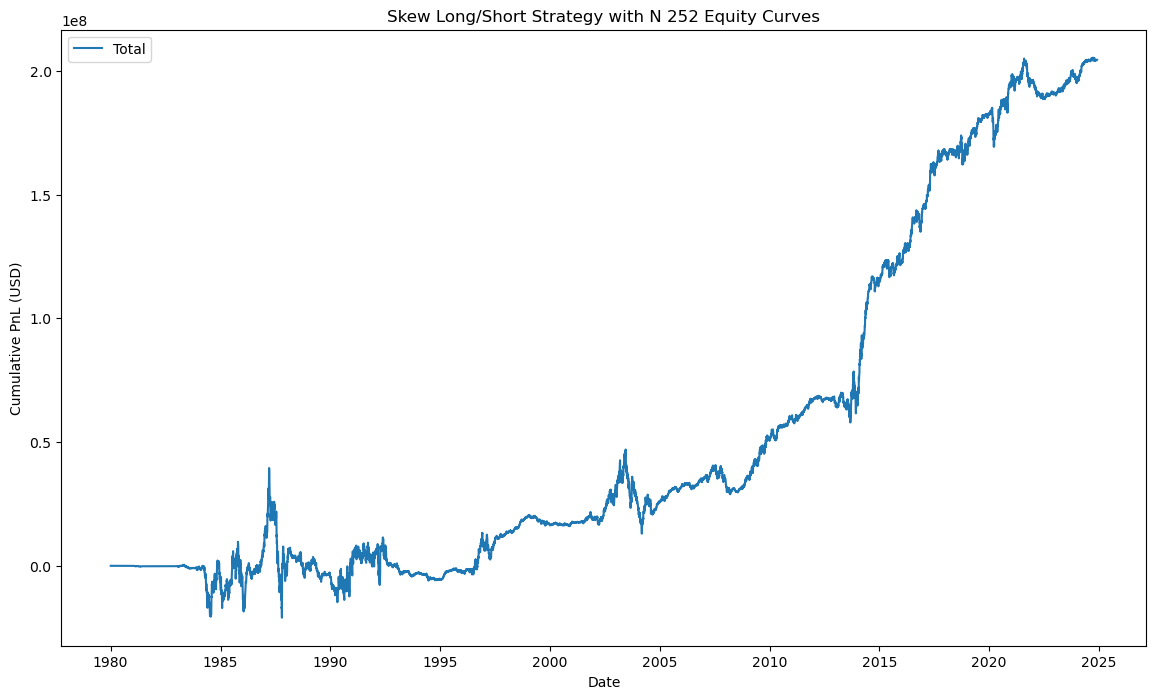

,Total
Date,
1980-01-02,0.00
1980-01-03,0.00
1980-01-04,0.00
1980-01-07,0.00
1980-01-08,0.00
...,...
2024-11-25,"204,365,682"
2024-11-26,"204,374,606"
2024-11-27,"204,389,445"


In [12]:
skew_combined.plot_equity()

In [13]:
startat = '01012000'
slong_stats = skew_long.calculate_statistics(byac=True, start_date=startat) 
sshort_stats = skew_short.calculate_statistics(byac=True, start_date=startat)
scomb_stats = skew_combined.calculate_statistics(byac=True, start_date=startat)

In [14]:

slong_stats.iloc[:, :20]


,Total PnL,Average Ann. PnL,Average Ann. Vol,Sharpe Ratio (ann.),Sortino Ratio (ann.),Max drawdown,Average drawdown,Max drawdown Duration,Avg Drawdown Duration,Total Number of Drawdowns,Drawdowns per year,HWM PnL,Exposure Time,Daily PnL Skew,Weekly PnL Skew,Monthly PnL Skew,Quarterly PnL Skew,Yearly PnL Skew,Daily Left Tail,Daily Right Tail
Column,,,,,,,,,,,,,,,,,,,,
crypto,"2,180,958","84,658","177,820",0.48,0.21,"439,741","130,478",425,29.9,40,1.55,"2,359,459",6492,5.00,3.81,5.25,4.73,2.95,18.0,-22.3
fi-us,"25,301,911","982,144","2,320,592",0.42,0.42,"10,323,000","2,155,547",1153,45.2,129,5.01,"35,624,912",6492,0.43,-0.09,0.39,0.37,0.33,28.2,49.8
eq-em,"14,769,404","573,304","959,638",0.60,0.65,"4,096,433","703,382",1288,41.2,143,5.55,"15,515,967",6492,-0.26,0.51,0.81,1.45,1.54,5.47,4.98
fi-eu,"73,473,461","2,852,020","3,337,933",0.85,0.87,"9,033,131","1,485,250",1039,26.3,228,8.85,"76,721,049",6492,-0.63,-0.24,0.55,1.67,1.77,5.90,6.96
eq-us,"15,125,238","587,116","2,081,793",0.28,0.23,"10,986,128","1,734,537",1727,60.4,102,3.96,"16,522,544",6492,-3.19,-3.02,-2.99,-1.94,0.86,44.1,15.5
eq-eu,"33,294,521","1,292,394","2,988,279",0.43,0.46,"8,031,556","1,961,764",2030,53.9,116,4.50,"33,672,155",6492,1.58,1.46,1.22,1.85,1.57,8.27,8.74
fi-as,"27,974,422","1,085,883","2,016,809",0.54,0.52,"9,371,158","4,337,676",2705,58.6,100,3.88,"31,472,438",6492,0.17,-1.56,0.26,1.87,2.24,19.7,84.4
Total,"192,119,915","7,457,520","6,770,189",1.10,1.34,"19,857,994","3,888,764",868,17.3,330,12.8,"198,911,459",6492,-0.31,-0.38,-0.05,0.77,0.93,2.65,2.34


In [15]:
scomb_stats.iloc[:, :20]

,Total PnL,Average Ann. PnL,Average Ann. Vol,Sharpe Ratio (ann.),Sortino Ratio (ann.),Max drawdown,Average drawdown,Max drawdown Duration,Avg Drawdown Duration,Total Number of Drawdowns,Drawdowns per year,HWM PnL,Exposure Time,Daily PnL Skew,Weekly PnL Skew,Monthly PnL Skew,Quarterly PnL Skew,Yearly PnL Skew,Daily Left Tail,Daily Right Tail
Column,,,,,,,,,,,,,,,,,,,,
crypto,"1,390,671","53,982","212,993",0.25,0.13,"1,415,639","308,434",425,31.1,38,1.48,"2,408,367",6492,2.39,0.78,0.20,0.90,0.69,42.4,-42.8
fi-us,"15,002,771","582,363","3,303,291",0.18,0.18,"14,351,831","5,521,844",1860,66.3,91,3.53,"25,474,622",6492,-0.62,-0.21,1.02,0.56,-0.01,6.52,5.30
eq-em,"18,486,341","717,584","1,386,427",0.52,0.58,"3,971,694","1,080,475",2381,54.7,114,4.43,"19,534,865",6492,-0.11,0.86,2.30,2.22,2.17,4.04,4.80
fi-eu,"78,874,352","3,061,666","3,694,385",0.83,0.95,"8,453,312","1,503,552",1061,26.4,228,8.85,"81,525,016",6492,-0.49,-0.18,0.49,1.46,1.55,3.20,3.44
eq-us,"12,129,402","470,827","2,107,881",0.22,0.20,"11,327,303","2,196,571",1727,72.9,85,3.30,"14,135,820",6492,-3.15,-3.00,-2.98,-1.87,0.85,8.75,5.87
eq-eu,"24,481,656","950,305","4,755,904",0.20,0.23,"29,780,432","7,038,126",3640,127.6,50,1.94,"24,927,034",6492,0.68,0.80,-0.14,-0.78,-0.71,5.89,5.34
fi-as,"37,497,420","1,455,538","4,138,734",0.35,0.34,"13,966,092","4,401,040",2679,72.7,85,3.30,"40,875,537",6492,3.51,1.11,2.38,3.65,3.37,14.3,41.6
Total,"187,862,614","7,292,264","9,055,422",0.81,1.01,"33,994,930","6,584,007",1592,23.8,251,9.74,"188,696,684",6492,0.15,-0.09,0.18,0.63,1.11,2.54,2.42


In [16]:
sshort_stats.iloc[:, :20]

,Total PnL,Average Ann. PnL,Average Ann. Vol,Sharpe Ratio (ann.),Sortino Ratio (ann.),Max drawdown,Average drawdown,Max drawdown Duration,Avg Drawdown Duration,Total Number of Drawdowns,Drawdowns per year,HWM PnL,Exposure Time,Daily PnL Skew,Weekly PnL Skew,Monthly PnL Skew,Quarterly PnL Skew,Yearly PnL Skew,Daily Left Tail,Daily Right Tail
Column,,,,,,,,,,,,,,,,,,,,
stir,"-13,494,065","-523,477","2,000,737",-0.26,-0.23,"17,035,800","5,436,036",2044,235.5,25,0.97,"3,255,980",6496,-0.77,-0.74,-1.19,-1.61,-1.46,-46.3,42.5
comm-soft,"-12,957,090","-502,646","1,015,891",-0.49,-0.65,"16,964,904","6,586,979",5167,145.8,44,1.71,"3,191,937",6496,-0.08,-0.24,-0.80,-0.78,-1.13,2.34,2.30
eq-em,"-256,022","-9,932","608,485",-0.02,-0.02,"4,399,136","2,376,651",4196,121.2,49,1.90,"3,306,946",6496,0.19,0.35,0.14,0.01,0.03,-697.2,651.2
fx-em,"-5,773,422","-223,969","1,435,009",-0.16,-0.13,"15,462,092","7,057,475",6494,"6,494",1,0.04,"212,531",6496,0.81,-1.57,-2.46,-2.54,-0.15,-67.7,65.0
fx-dm,"1,895,123","73,518","1,276,357",0.06,0.06,"6,812,565","3,069,701",5773,221.8,29,1.12,"3,119,553",6496,-0.87,-1.10,-0.39,-0.02,0.04,5.69,4.29
fi-as,"-2,059,474","-79,893","368,531",-0.22,-0.09,"4,804,394","3,789,948",6318,706.4,9,0.35,"994,584",6496,-2.68,-2.72,-4.57,-6.46,-3.47,-52.3,54.2
eq-eu,"-16,233,559","-629,750","2,988,839",-0.21,-0.18,"27,223,268","19,063,682",5663,240.1,25,0.97,"7,537,129",6496,0.34,0.30,-0.78,-2.34,-2.16,-60.6,60.1
comm-enrgy,"-16,073,865","-623,555","2,076,492",-0.30,-0.38,"18,639,845","10,034,712",6490,"6,490",1,0.04,"197,476",6496,0.69,0.21,0.09,-0.02,-0.27,3.17,3.55
fi-eu,"8,058,803","312,626","2,261,368",0.14,0.10,"10,561,997","4,018,863",2816,176.0,34,1.32,"13,335,580",6496,-0.65,-0.05,0.23,0.27,1.71,95.2,-89.1


In [17]:
metric = 'sharpe'

tr = skew_long

t = tr.perf_table(metric=metric)
t = t.iloc[:, :20]
t = t.fillna('')
if metric == 'pnl' or metric == 'vol' or metric=='maxdd':
    t = t.replace(0, '')
    t = t.map(lambda x: x / 1_000_000 if isinstance(x, (int, float)) else x)
t

Period                  2024 2023  2022  2021  2020  2019  2018  2017  2016  \
AssetClass Asset                                                              
Unknown    Total        1.97 2.37 -2.17  0.04  1.13  2.68  0.29  2.04  1.84   
crypto     BTC1 Curncy       1.18 -0.50  1.47  2.64  1.86 -0.03               
           DCR1 Curncy       0.90 -0.88                                       
eq-em      HC1 Index              -0.63 -0.88 -0.62  1.99 -0.78  1.77 -0.63   
           KM1 Index   -1.13                  -1.12  0.84 -1.40  2.36  0.89   
           MES1 Index              0.11  0.15  1.35  2.20 -1.12  1.94 -0.34   
           QZ1 Index    1.76 0.68 -0.50  1.20 -0.74 -0.02 -0.93  0.93 -1.00   
           XB1 Index               0.07 -0.58  1.12  1.66  0.21  1.36         
           XU1 Index              -1.44  0.39  2.30  1.77 -1.16  1.50  0.14   
           ZVL1 Index   0.00 1.79 -0.70  0.93  2.10 -0.25 -0.57  1.97 -0.06   
eq-eu      CA1 Index    2.20 1.61  0.44  0.42  0.73  0.90 -1.34  1.09  1.27   
           CF1 Index    0.43 1.63 -0.91  1.38 -0.05  1.38 -1.47  0.89  1.36   
           GX1 Index    1.31 2.20 -0.98  0.30  0.17  1.00 -1.87  0.91  1.29   
           IB1 Index    1.27 1.59 -0.30  0.67  0.08  0.83 -0.31  1.46  1.07   
           QC1 Index    1.37      -1.20  2.27  0.49  1.50 -1.36  0.71  1.12   
           SM1 Index    0.80      -1.23  0.83  0.60  1.45  0.42       -1.23   
           ST1 Index    1.87 1.46 -0.69  1.18  0.67  0.59        0.98  0.78   
           VG1 Index    1.54 1.79 -1.12  1.31 -0.10  1.27 -1.24  0.94  1.54   
           Z 1 Index    0.32 0.07 -0.27  0.74 -0.41  1.08 -0.93  1.40 -0.26   
eq-us      DM1 Index    0.80      -0.52  0.36 -0.16  1.64 -0.13  1.63  1.06   
           ES1 Index    1.38      -0.93  1.21  0.25  1.90 -0.41  1.39  0.45   
           NQ1 Index    0.60      -1.14  0.98  1.21  1.75  0.17  1.89  0.09   
           RTY1 Index                    0.88  1.03  1.61 -1.71               
fi-as      JB1 Comdty   0.66 1.22 -0.95 -0.71  0.39  1.34  2.42  1.09  0.57   
           KAA1 Comdty  0.73 2.23 -1.84 -1.22 -0.62        0.90 -0.83  1.01   
fi-eu      BTS1 Comdty             0.86 -0.31 -0.35  1.34  0.50 -1.11  0.04   
           DU1 Comdty              1.11  0.00  1.95 -0.96  1.16  0.74  1.71   
           G 1 Comdty                   -0.41  1.43 -0.49 -0.84  0.36         
           IK1 Comdty             -0.03 -0.82  2.42  1.83  0.27  0.47 -0.11   
           OAT1 Comdty                  -1.23  0.61  1.81  0.65  0.80  1.10   
           OE1 Comdty                   -0.61  0.09        0.83  0.06  1.50   
           RX1 Comdty                   -0.79  0.60 -0.90  0.32  0.35  1.46   
           UB1 Comdty                   -0.73  1.03 -1.20  0.73  0.04  2.10   
fi-us      CN1 Comdty                    0.63                          0.77   
           FV1 Comdty             -2.29 -0.53                                 
           TU1 Comdty             -1.96 -1.36                                 
           TY1 Comdty             -1.50 -0.04 -0.74                    1.46   
           US1 Comdty  -1.10            -0.47 -0.66       -1.95  0.46  1.10   
           WN1 Comdty  -0.44             1.38             -1.07  0.65  1.54   

Period                  2015  2014  2013  2012  2011  2010  2009  2008  2007  \
AssetClass Asset                                                               
Unknown    Total        0.69  4.34  0.18  0.92  1.75  3.18  1.70  0.15  0.24   
crypto     BTC1 Curncy                                                         
           DCR1 Curncy                                                         
eq-em      HC1 Index                           -0.22                           
           KM1 Index    1.15 -1.27        0.62 -0.13  2.03  0.22 -0.32  1.70   
           MES1 Index   0.36 -0.71        0.17 -0.67                           
           QZ1 Index   -1.19  0.03  0.22  1.26 -0.99              0.66  0.66   
           XB1 Index         -0.28      

In [18]:
skew_long.strat_monthly_pnl()

,1,2,3,4,5,6,7,8,9,10,11,12,Annual_PnL,Sharpe_Ratio,Annual_Vol,Hit_Rate,Profit_Factor,Worst_Drawdown
Year,,,,,,,,,,,,,,,,,,
1980,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00
1981,"-84,788","-113,848","27,391","-161,926","90,926","10,698",0.00,0.00,0.00,0.00,0.00,0.00,"-231,547",-0.92,"250,168",0.43,0.81,"-401,279"
1982,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"7,994","7,994",0.09,"85,555",0.41,1.06,"-63,033"
1983,"-204,310","339,530","-52,544","324,224","-804,059","28,377","-556,746","-16,667","204,818","-131,097","18,599","34,095","-815,781",-0.63,"1,273,331",0.49,0.88,"-2,394,172"
1984,"-377,140","215,509","361,454","-1,863,634","-2,772,962","148,880","-857,525","2,177,293","491,795","241,149","776,132","-1,396,307","-2,855,356",-0.74,"3,792,633",0.50,0.89,"-6,165,402"
1985,"-863,090","-152,397","1,107,229","-151,753","423,182","29,354","1,793,511","-19,356","371,156","-46,373","-369,132","-1,083,022","1,039,309",0.25,"4,060,633",0.47,1.04,"-2,861,869"
1986,"-1,459,101","2,240,069","3,354,757","36,007","-2,723,147","1,367,937","99,375","1,698,203","-1,487,656","1,275,023","1,365,674","1,908,759","7,675,898",1.42,"5,246,781",0.58,1.26,"-5,011,383"
1987,"1,650,551","2,380,718","-601,430","-2,516,382","-458,166","-880,695","-2,615,782","-2,618,991","-2,844,897","2,846,277","53,643","16,355","-5,588,797",-0.69,"7,827,444",0.51,0.89,"-18,516,244"
1988,"2,736,601","212,243","-1,792,234","-973,493","-30,576",0.00,"4,595","17,122","191,190","205,422","-185,131","44,353","430,093",0.13,"3,216,195",0.55,1.04,"-3,173,620"


In [19]:
skew_combined.strat_monthly_pnl()

,1,2,3,4,5,6,7,8,9,10,11,12,Annual_PnL,Sharpe_Ratio,Annual_Vol,Hit_Rate,Profit_Factor,Worst_Drawdown
Year,,,,,,,,,,,,,,,,,,
1980,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00
1981,"-50,496","-113,303","27,034","-163,091","89,984","25,781",0.00,0.00,0.00,0.00,0.00,0.00,"-184,090",-0.73,"250,024",0.43,0.84,"-402,348"
1982,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"46,081","46,081",0.48,"95,533",0.47,1.32,"-66,491"
1983,"-209,390","346,924","-53,395","324,649","-779,169","28,282","-545,695","-26,805","204,884","-123,348","254,513","34,154","-544,398",-0.41,"1,292,708",0.49,0.92,"-2,176,548"
1984,"-378,018","220,983","346,952","-4,505,322","-10,000,733","405,605","-4,087,408","11,030,115","2,585,988","1,285,500","3,967,341","-7,481,369","-6,610,364",-0.42,"15,461,917",0.50,0.93,"-20,566,519"
1985,"-5,218,603","262,226","4,589,213","-861,813","842,275","227,917","9,195,914","-81,240","2,348,789","-315,369","-2,291,583","-6,820,360","1,877,365",0.08,"21,927,681",0.47,1.02,"-17,922,920"
1986,"-9,280,759","7,902,295","6,053,990","-23,899","-3,500,832","1,866,431","223,917","2,451,667","-1,455,670","2,553,735","2,585,305","4,298,813","13,674,993",1.01,"13,082,382",0.57,1.22,"-11,931,398"
1987,"4,076,393","10,613,526","4,337,588","-3,582,988","-34,129","-6,069,205","-12,160,296","-10,182,625","-4,745,834","9,649,969","915,199","-1,384,947","-8,567,350",-0.29,"28,995,215",0.51,0.95,"-60,479,180"
1988,"6,407,181","630,179","-2,815,611","-539,448","567,811","-1,737,833","1,141,931","868,317","-5,322,741","-3,769,968","4,660,163","582,962","672,943",0.07,"9,462,847",0.51,1.01,"-12,186,475"
